In [1]:
# this ensures that the notebook is always reloaded in the same state
from example_utils import *

# remove all previous experiments
!rm -rf my_experiment 
!rm -rf my-talkative-experiments
!rm -rf linear_regression

# Digital Experiments

## The Basics

At its most basic, a digital experiment is a peice of code that takes some inputs and produces some results.

To keep track of these inputs and results automatically, `digital_experiments` provides the `@experiment` decorator:

In [2]:
from digital_experiments import experiment

@experiment
def my_experiment(a, b, power=2):
    return (a - b) ** power + a

Running an experiment and recording the output is as simple as calling the function:

In [3]:
my_experiment(1, 2)

2

We can see that digital_experiments logs that an experiment has occurred, together with the arguments used to run it (including defaults from the function that we didn't pass!)

By default, a folder to hold all of these experiments is created with the name of the function (in this case `my_experiment`). 

Each call of the function corresponds to a single experiment. These are named with the timestep at which they were started (so that they appear in chronological order within file systems) together with a human readable identifier, and appear as sub-folders:

In [4]:
tree("my_experiment")

├── .backend
├── 221116-140837-4975-numb-shoe
│   ├── config.json
│   ├── metadata.json
│   └── results.json
└── code.py


Under-the-hood, `digital_experiments` has saved everything we want to know about this experiment!

We can inspect experiment files directly from the file system:

In [5]:
!cat my_experiment/*/config.json

{
    "a": 1,
    "b": 2,
    "power": 2
}

... and also access them from within python:

In [6]:
from digital_experiments import all_experiments
all_experiments(my_experiment)

,id,a,b,power,result
0,221116-140837-4975-numb-shoe,1,2,2,2


## Advanced Usage

### Logging and Verbosity

The experiment decorator can take several keyword arguments:
- `save_to` specifies the folder to save all experiments to (defaults to the name of the function)
- `capture_logs` - if this is set to True, anything printed from within the experiment is saved to `log`
- `verbose` - controls whether `digital_experiments` prints additional information about each experiment

In [7]:
@experiment(save_to="my-talkative-experiments", verbose=True, capture_logs=True)
def talkative_experiment(a, b, power=2):
    print("Hello!")
    return (a - b) ** power + a

talkative_experiment(1, 2)

Starting new experiment - 221116-140837-9229-blue-main
Arguments: {
    "a": 1,
    "b": 2,
    "power": 2
}
Hello!
Finished experiment - 221116-140837-9229-blue-main



2

In [8]:
!cat my-talkative-experiments/*/log

Hello!


### Multiple Results and Artefacts

It is often the case that we have more than a single result.
`digital_experiments` can handle these intelligently when they are returned as an (optionally nested) dict.

Artefacts can be automatically be saved in the correct folder using the `current_directory` function:

In [9]:
import pickle
import numpy as np
from sklearn.linear_model import Ridge
from digital_experiments import current_directory

np.random.seed(6)

X = np.random.rand(100, 3) * 20
y = X[:,0] * 2 + X[:,1] * 4 + 2 + np.random.randn(100) * 5


@experiment(verbose=False)
def linear_regression(alpha, fit_intercept=True):
    model = Ridge(alpha, fit_intercept=fit_intercept)
    train, test = slice(0, 10), slice(90, 100)

    model.fit(X[train], y[train])
    yhat = model.predict(X)
    errors = yhat - y

    with open(current_directory() / "model.pkl", "wb") as f:
        pickle.dump(model, f)

    return {
        "mae": {
            name: np.abs(errors[split]).mean()
            for name, split in zip(["train", "test"], [train, test])
        },
        "rmse": {
            name: (errors[split] ** 2).mean() ** 0.5
            for name, split in zip(["train", "test"], [train, test])
        }
    }


linear_regression(alpha=0)

{'mae': {'train': 0.9737829415128569, 'test': 5.615792030139374},
 'rmse': {'train': 1.1536968041748403, 'test': 7.186958533952817}}

In [10]:
for alpha in range(1, 10):
    linear_regression(alpha * 5)

Nested results are flattened using ".":

In [11]:
df = all_experiments("linear_regression")
df

,id,alpha,fit_intercept,mae.train,mae.test,rmse.train,rmse.test
0,221116-140838-4941-smug-text,0,True,0.973783,5.615792,1.153697,7.186959
1,221116-140838-5662-drab-burn,5,True,1.078108,5.240720,1.267344,6.813575
2,221116-140838-5689-wiry-clue,10,True,1.304290,4.899661,1.534452,6.520374
3,221116-140838-5702-real-rent,15,True,1.575662,4.716825,1.865973,6.298366
4,221116-140838-5709-mild-fall,20,True,1.912852,4.628257,2.217161,6.139268
5,221116-140838-5715-left-bake,25,True,2.267020,4.550531,2.569086,6.035315
6,221116-140838-5721-weak-unit,30,True,2.600822,4.517051,2.913901,5.979203
7,221116-140838-5730-idle-exam,35,True,2.916348,4.663442,3.248451,5.964124
8,221116-140838-5738-grim-sale,40,True,3.215390,4.804743,3.571648,5.983819
9,221116-140838-5745-slow-idea,45,True,3.499491,4.941329,3.883356,6.032641


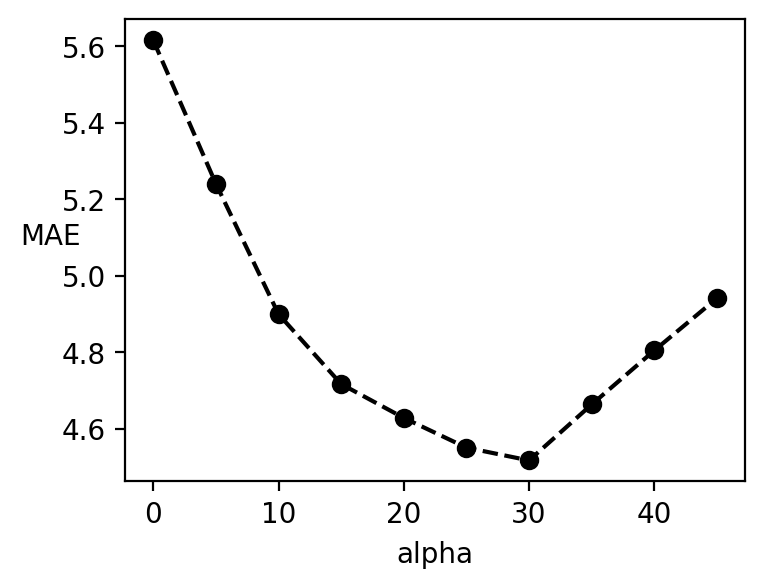

In [12]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(4, 3))
plt.plot(df.alpha, df['mae.test'], "--ko")
plt.xlabel("alpha")
plt.ylabel("MAE", rotation=0);

Artefacts saved during an experiment can be accessed using `.artefacts`: a mapping of filename to actual path.

In [13]:
from digital_experiments.core import get_artefacts
get_artefacts("linear_regression", df.id[0])

{'model.pkl': PosixPath('linear_regression/221116-140838-4941-smug-text/model.pkl')}

### Template Matching

When accessing experiments, we can filter them based on their config and results:

In [14]:
from digital_experiments import experiments_matching

# exact matches
experiments_matching("linear_regression", alpha=0)

,id,alpha,fit_intercept,mae.train,mae.test,rmse.train,rmse.test
0,221116-140838-4941-smug-text,0,True,0.973783,5.615792,1.153697,7.186959


In [15]:
# function matches
experiments_matching("linear_regression", alpha=lambda x: x < 20)

,id,alpha,fit_intercept,mae.train,mae.test,rmse.train,rmse.test
0,221116-140838-4941-smug-text,0,True,0.973783,5.615792,1.153697,7.186959
1,221116-140838-5662-drab-burn,5,True,1.078108,5.240720,1.267344,6.813575
2,221116-140838-5689-wiry-clue,10,True,1.304290,4.899661,1.534452,6.520374
3,221116-140838-5702-real-rent,15,True,1.575662,4.716825,1.865973,6.298366


In [16]:
# nested filtering:

template = {
    'mae': {"test": lambda x: x < 4.7}
}
experiments_matching("linear_regression", template)

,id,alpha,fit_intercept,mae.train,mae.test,rmse.train,rmse.test
4,221116-140838-5709-mild-fall,20,True,1.912852,4.628257,2.217161,6.139268
5,221116-140838-5715-left-bake,25,True,2.267020,4.550531,2.569086,6.035315
6,221116-140838-5721-weak-unit,30,True,2.600822,4.517051,2.913901,5.979203
7,221116-140838-5730-idle-exam,35,True,2.916348,4.663442,3.248451,5.964124


## Versions

`digital_experiments` also keeps track of the versions of the code used to run an experiment.
If the code of the experiment changes, a new version is created in the file system (i.e. old experiments are not overwritten). Reverting the code back to an older version will continue writing to the correct folder.

In [17]:
@experiment
def my_experiment(a, b=2):
    return a + b

my_experiment(1)

3

In [18]:
tree("my_experiment")

├── v-1
│   ├── .backend
│   ├── 221116-140837-4975-numb-shoe
│   │   ├── config.json
│   │   ├── metadata.json
│   │   └── results.json
│   └── code.py
└── v-2
    ├── .backend
    ├── 221116-140839-5969-dark-baby
    │   ├── config.json
    │   ├── metadata.json
    │   └── results.json
    └── code.py


In [19]:
!cat my_experiment/*/code.py

@experiment
def my_experiment(a, b, power=2):
    return (a - b) ** power + a
@experiment
def my_experiment(a, b=2):
    return a + b


## Backends

`digital_experiments` can be used with any backend that implements the `Backend` interface.
`json` and `csv` backends are provided out of the box:

In [20]:
@experiment(backend="csv")
def my_experiment(a, b=2):
    return a + b

my_experiment(1)

3

In [21]:
tree("my_experiment")

├── v-1
│   ├── .backend
│   ├── 221116-140837-4975-numb-shoe
│   │   ├── config.json
│   │   ├── metadata.json
│   │   └── results.json
│   └── code.py
├── v-2
│   ├── .backend
│   ├── 221116-140839-5969-dark-baby
│   │   ├── config.json
│   │   ├── metadata.json
│   │   └── results.json
│   └── code.py
└── v-3
    ├── .backend
    ├── code.py
    ├── headers.map
    └── results.csv


In [22]:
!cat my_experiment/v-3/results.csv

id,a,b,result,_time.start,_time.end,_context
221116-140840-0678-that-dust,1,2,3,1668607720.068085,1668607720.068096,manual
